# pip installs

In [1]:
# !pip install -q -U git+https://github.com/UKPLab/sentence-transformers
# !pip install -q -U tensorflow # solve pipeline import issue on transformers ~= 4.6.1
# !pip install -q -U transformers soynlp emoji

# import things

In [2]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, BertTokenizer
from transformers import FillMaskPipeline
import requests
import pandas as pd
import torch
from glob import glob
import json

torch.__version__

'1.8.1+cu111'

# Tweet collect & clean

In [3]:
import re
import emoji
from soynlp.normalizer import repeat_normalize

emojis = ''.join(emoji.UNICODE_EMOJI.keys())
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
rt_pattern = re.compile(r'@.+')

def clean(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = rt_pattern.sub('', x)
    if x.startswith('RT'):
        x = x[2:]
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

In [4]:
def get_tweets(q='오드트유'):
    pat = re.compile(q)
    
    if files := [i for i in glob('./data/*/*.json') if q in i]:
        res = []
        for i in files:
            res += json.load(open(i))
        original = [k for k in {clean(i) for i in res} if len(pat.findall(k)) == 1 and len(k) > 20]
        masked = [k.replace(q, '[MASK]') for k in original]
        return {
            'original': original,
            'masked': masked,
        }
    else:
        r = requests.get('https://api.twitter.com/1.1/search/tweets.json', headers={
            'Authorization': 'TwitterTOKEN',
        }, params={
            'q': f'"{q}"',
            'count': 100,
            'include_entities': False,
        })
        original = [k for k in {clean(i['text']) for i in r.json()['statuses']} if len(pat.findall(k)) == 1 and len(k) > 20]
        masked = [k.replace(q, '[MASK]') for k in original]
        return {
            'original': original,
            'masked': masked
        }

# Build EvergreenBERT Model

In [5]:
def get_orignal_model(base_model='beomi/kcbert-base'):
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    model = AutoModelForMaskedLM.from_pretrained(base_model)
    model.eval()
    return tokenizer, model

In [6]:
def create_evergreen_bert(base_model='beomi/kcbert-base', added_tokens=['오드트유', '오드투유']):
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    model = AutoModelForMaskedLM.from_pretrained(base_model)
    model.eval()
    pipeline = FillMaskPipeline(model, tokenizer, top_k=10)
    
    def get_usable_logits(x):
        usable_logits = []
        for i in x:
            if i['token_str'].startswith('##'):
                continue
            if len(i['token_str']) < 2:
                continue
            usable_logits.append(i)
        return usable_logits
    
    # Vocab별 Vector 추출 from PLM
    added_vocab_embs = {}
    for added_token in added_tokens:
        masked_tweets = get_tweets(added_token)['masked']
        tweet_size = len(masked_tweets)
        
        mask_predictions = pipeline(masked_tweets)
        dfs = []
        for i in mask_predictions: # 각 Sentence별 Mask후 Inference
            df = pd.DataFrame(get_usable_logits(i))
            if len(df):
                sum_score = df['score'].sum()
                df['score'] = df['score'].map(lambda x: x/sum_score)
                dfs.append(df)
        df_all = pd.concat(dfs)

        def get_non_contextualized_embeding(df_all, tweet_size):
            embs = df_all.apply(lambda x: model.bert.embeddings.word_embeddings.weight[x['token']] * x['score'], axis=1)
            return embs.sum() / tweet_size

        added_vocab_embs[added_token] = get_non_contextualized_embeding(df_all, tweet_size).detach()
    
    evergreen_tokenizer = AutoTokenizer.from_pretrained(base_model)
    evergreen_model = AutoModelForMaskedLM.from_pretrained(base_model)
    evergreen_tokenizer.add_tokens(added_tokens)
    evergreen_model.resize_token_embeddings(len(evergreen_tokenizer))
    
    tokenizer_length = len(tokenizer)
    vocabs = evergreen_tokenizer.vocab.keys()
    for idx, added_token in enumerate(added_tokens):
        if added_token in vocabs:
            continue
        with torch.no_grad():
            evergreen_model.bert.embeddings.word_embeddings.weight[tokenizer_length+idx] = added_vocab_embs[added_token]
    
    return evergreen_tokenizer, evergreen_model

In [7]:
new_vocabs = list({
    i.split('/')[-1].split()[0].replace('.json', '') 
    for i in glob('./data/*/*.json') if len(i.split('/')[-1].split()) == 1
})
new_vocabs

['일어낫다',
 '원더케이',
 '강다니엘',
 '자이언츠',
 '프리허그',
 '기립박수',
 '스물두번째생일',
 '자컾연성',
 '대면팬싸',
 '사운드트랙',
 '젠더퀴어',
 '취향겹침표',
 '전과목A',
 '생일너무너무',
 '자빱사단',
 '뉴스원샷',
 '이글읽고난다음',
 '배경화면',
 '로또사서',
 '박지훈X',
 '수련언니',
 '안경에이스',
 '뮤직뱅크',
 '기습공격',
 '경멸하나',
 '무사만루',
 '판타블렛',
 '느낌표느낌표',
 '딥상어동',
 '생일해시',
 '철인3종경기',
 '라플라스',
 '불우이웃',
 '수지서현',
 '물고기들',
 '군수송기',
 '총공총공',
 '푸른비늘',
 '쫀아에용',
 '동물농장',
 '투르크메니스탄',
 '안무영상',
 '맛집여행',
 '헤럴드POP',
 '반달모양',
 '시스젠더',
 '취업준비',
 '제이굿즈',
 '아쿠아리움',
 '섬온화님',
 '디저트39',
 '신규확진',
 '전공공부',
 '연습영상',
 '연성문장',
 '불로장생',
 '헬로헬로',
 '아웃카운트',
 '파트분배',
 '아이돌등판',
 '모닝커피',
 '드레이코',
 '경멸신한',
 '스타뉴스',
 '페인킬러',
 '셀카듀스',
 '사법연수원',
 '심야영화',
 '기레기들',
 '다크몬스터',
 '감방생활',
 '바다동물',
 '펜트하우스',
 '로드스터',
 '북극바다',
 '자빱티비',
 '개인그림',
 '가정했을때']

In [8]:
ev_t, ev_m = create_evergreen_bert(added_tokens=new_vocabs)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model

In [9]:
!mkdir EvergreenBERT_word

In [10]:
ev_t.save_pretrained('./EvergreenBERT_word')
ev_m.save_pretrained('./EvergreenBERT_word')

# Convert EvergreenBERT to Evergreen-SBERT

In [11]:
from sentence_transformers import SentenceTransformer, models

## Pretrained MLM Pooling

In [12]:
kcbert_sbert = SentenceTransformer('beomi/kcbert-base')

## EvergreenBERT MLM Pooling

In [13]:
evergreen_sbert_transformers = models.Transformer('./EvergreenBERT_word')
evergreen_sbert_pooling = models.Pooling(evergreen_sbert_transformers.get_word_embedding_dimension())

evergreen_sbert = SentenceTransformer(modules=[evergreen_sbert_transformers, evergreen_sbert_pooling])

Some weights of the model checkpoint at ./EvergreenBERT_word were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ./EvergreenBERT_word and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
Y

# SBERT Encode

- 새로운 Vocab이 아닌 기존의 vocab만 사용하는 문장의 경우, 동일한 Representation을 뱉는다.
- 새로운 Vocab (ex: 펜트하우스)이 포함된 문장의 경우, 다른 Representation이 나온다.

In [14]:
kcbert_sbert.encode("안녕하세요, 반가워요.") == evergreen_sbert.encode("안녕하세요, 반가워요.")

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [15]:
# 새로 추가된 단어: 오드트유
kcbert_sbert.encode("안녕하세요, 펜트하우스 방송 봅시다.") == evergreen_sbert.encode("안녕하세요, 펜트하우스 방송 봅시다.")

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

# Evaluate within Crawled dataset

- 신조어 자체에 좋은 Representation이 나타나는지 검증하는 것이 어려움
- 따라서, 여기서는 신조어 Query로 검색된 유사/동일 Tweet간 Similarity Score를 비교해 본다.
- 발견가능한 패턴: 오 #드 #트 #유 로 쪼개지는 경우에 -> 해당 부분으로 인해 더 높은 Cosine Similarity 값이 나온다.
- 즉, Sub-word로 쪼개지는 경우 SBERT로 Sentence Represenataion을 할 때 

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
kcbert_sbert.encode(['안녕', '반가워',''])

array([[-0.5428092 , -0.9914443 ,  1.250398  , ...,  0.5745559 ,
         0.80080956,  0.52963036],
       [ 0.6169529 , -0.38929334,  0.42200762, ...,  0.910913  ,
         0.00548372,  0.7092602 ],
       [ 0.01212531, -1.5130467 ,  1.3017178 , ...,  0.18010984,
         0.08382833,  0.41437015]], dtype=float32)

In [18]:
def get_multiple_similarity(q1, q2, model):
    np.random.seed(42)
    if torch.cuda.is_available():
        model.cuda()
    
    q1_tweets = get_tweets(q1)['original']
    
    if len(q1_tweets) > 20:
        q1_tweets = np.random.choice(q1_tweets, 20, replace=False)
    if q1 == q2:
        q2_tweets = q1_tweets
        encoded_q1 = model.encode(q1_tweets)
        encoded_q2 = encoded_q1
    else:
        q2_tweets = get_tweets(q2)['original']
        if len(q2_tweets) > 20:
            q2_tweets = np.random.choice(q2_tweets, 20, replace=False)
        encoded_q1 = model.encode(q1_tweets)
        encoded_q2 = model.encode(q2_tweets)
    
    sims_1 = []
    print(len(q1_tweets), len(q2_tweets))
    
    for i in encoded_q1:
        for j in encoded_q2:
            if list(i) != list(j):
                sims_1.append(cosine_similarity([i], [j])[0][0])
    return np.mean(sims_1)

In [19]:
# Not updated vocab, Same Result
get_multiple_similarity('오드트유', '오드트유', evergreen_sbert),\
get_multiple_similarity('오드트유', '오드트유', kcbert_sbert)

20 20
20 20


(0.60057676, 0.60057676)

In [20]:
# Updated vocab case, different similairties
get_multiple_similarity('펜트하우스', '펜트하우스', evergreen_sbert),\
get_multiple_similarity('펜트하우스', '펜트하우스', kcbert_sbert)

20 20
20 20


(0.4350466, 0.55809313)

# Evaluation

In [21]:
df = pd.DataFrame(new_vocabs, columns=['text'])
df.head()

,text
0,일어낫다
1,원더케이
2,강다니엘
3,자이언츠
4,프리허그


In [22]:
df['evergreen'] = df['text'].map(lambda x: get_multiple_similarity(x,x, evergreen_sbert))
df['kcbert'] = df['text'].map(lambda x: get_multiple_similarity(x,x, kcbert_sbert))

20 20
20 20
20 20
20 20
20 20
20 20
20 20
16 16
20 20
20 20
20 20
20 20
10 10
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
15 15
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
19 19
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
16 16
20 20
20 20
20 20
20 20
10 10
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
15 15
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
19 19
20 20
20 20
20 20
20 20
20 20
20 20


In [23]:
df.head()

,text,evergreen,kcbert
0,일어낫다,0.472729,0.509837
1,원더케이,0.541915,0.591731
2,강다니엘,0.524014,0.524014
3,자이언츠,0.484593,0.553775
4,프리허그,0.484628,0.553347


In [24]:
df_idx = df.sort_values('evergreen').reset_index().drop('index', axis=1).reset_index()
df_idx.head()

,index,text,evergreen,kcbert
0,0,펜트하우스,0.435047,0.558093
1,1,아웃카운트,0.454976,0.546227
2,2,사운드트랙,0.459666,0.511467
3,3,기습공격,0.461756,0.505856
4,4,대면팬싸,0.463688,0.521959


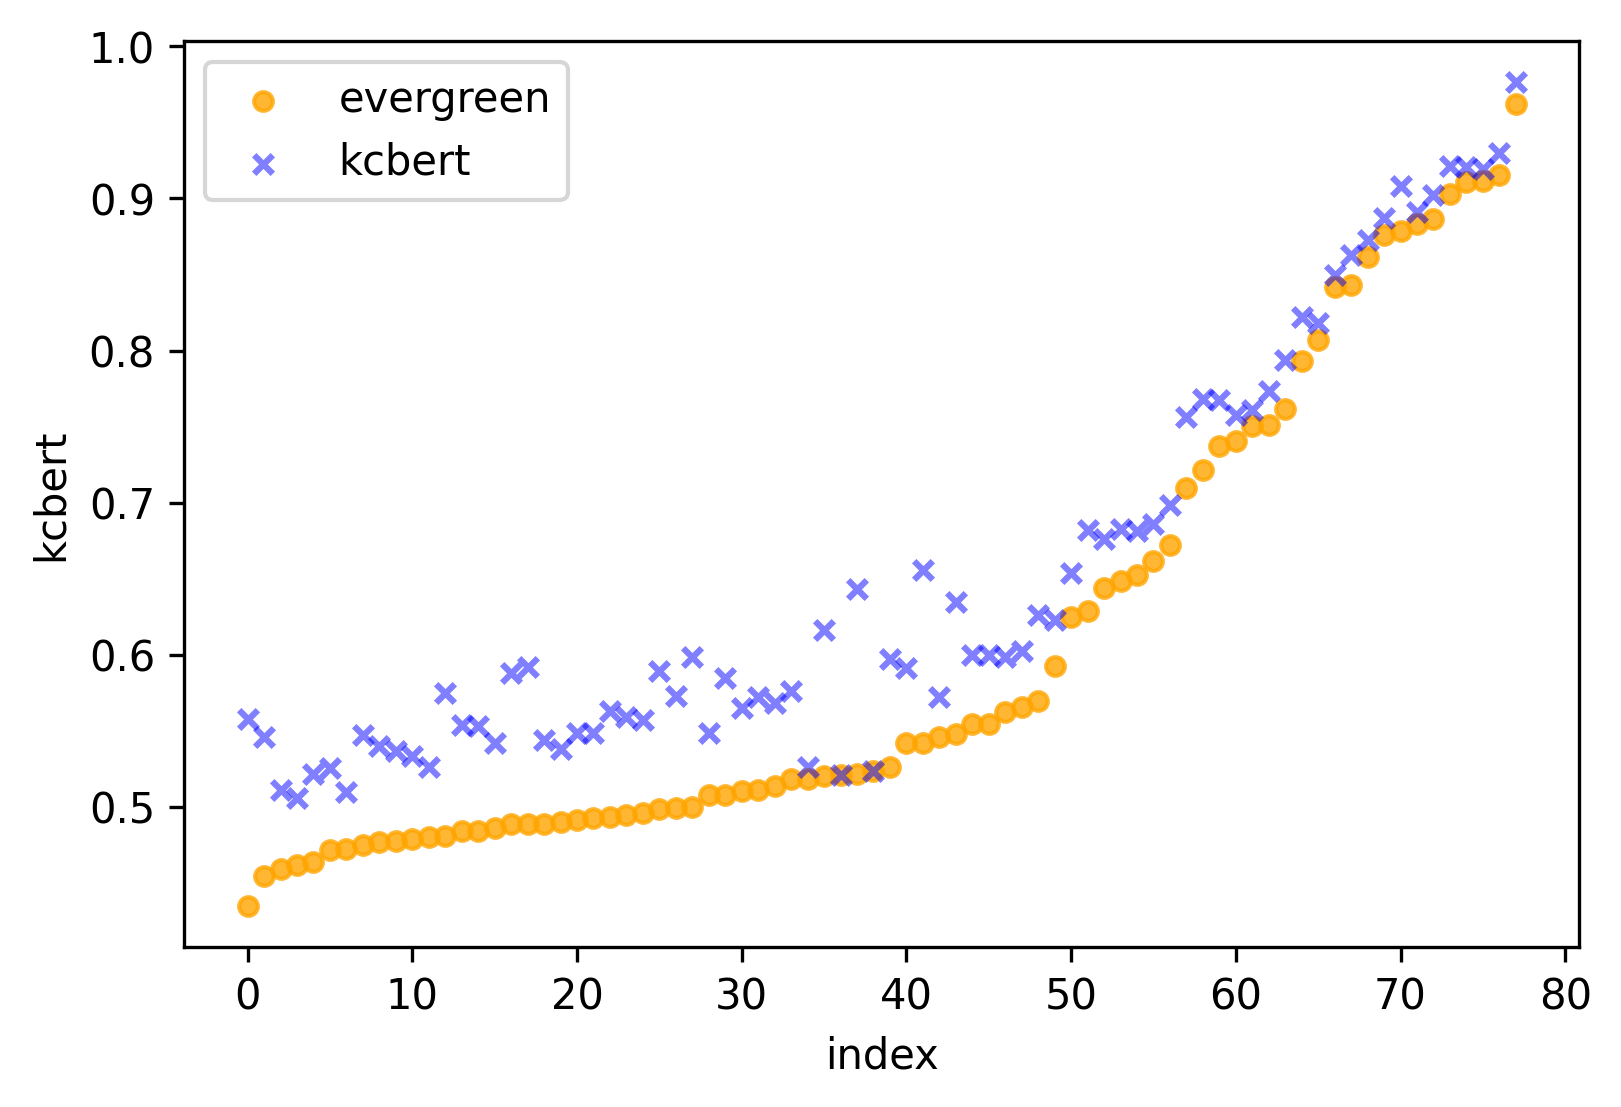

In [25]:
import matplotlib.pylab as plt
plt.rcParams["figure.dpi"] = 300

ax = df_idx.plot(kind='scatter', x='index', y='evergreen', color='orange', alpha=0.8)
df_idx.plot(kind='scatter', x='index', y='kcbert', color='blue',  alpha=0.5, ax=ax, marker='x')
ax.legend(['evergreen', 'kcbert'])